In [2]:
import yfinance as yf
import numpy as np
import pandas as pd

from prophet import Prophet
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams["figure.dpi"] = 150
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

import warnings
warnings.filterwarnings("ignore")

In [3]:
stock_id = '2330.TW'
df = yf.Ticker(stock_id).history(period="max")

In [7]:
df['Date'] = df.index
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date
Date,,,,,,,,
2022-08-18,520.0,521.0,519.0,520.0,17831084,0.0,0.0,2022-08-18
2022-08-19,519.0,523.0,517.0,519.0,14022812,0.0,0.0,2022-08-19
2022-08-22,511.0,514.0,510.0,512.0,11494000,0.0,0.0,2022-08-22
2022-08-23,503.0,506.0,502.0,504.0,19191108,0.0,0.0,2022-08-23
2022-08-24,504.0,508.0,503.0,503.0,14782282,0.0,0.0,2022-08-24


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5655 entries, 2000-01-04 to 2022-08-24
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Open          5655 non-null   float64       
 1   High          5655 non-null   float64       
 2   Low           5655 non-null   float64       
 3   Close         5655 non-null   float64       
 4   Volume        5655 non-null   int64         
 5   Dividends     5655 non-null   float64       
 6   Stock Splits  5655 non-null   float64       
 7   Date          5655 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 397.6 KB


In [12]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5655.000000,5655.000000,5655.000000,5655.000000,5.655000e+03,5655.000000,5655.000000
mean,121.682424,122.612573,120.621903,121.655963,2.009188e+10,0.016380,0.001959
std,152.030310,153.026931,150.796015,151.934075,4.293525e+10,0.262836,0.046861
min,13.876827,14.194135,13.837307,14.114713,0.000000e+00,0.000000,0.000000
25%,30.907079,31.358088,30.455016,30.928751,2.917450e+07,0.000000,0.000000
50%,48.420512,48.904026,48.132453,48.558659,4.505304e+07,0.000000,0.000000
75%,153.476635,154.739837,152.845064,154.108246,2.422635e+10,0.000000,0.000000
max,677.941488,680.910575,671.013619,675.962097,4.476381e+11,8.000000,1.400000


<AxesSubplot:xlabel='Date'>

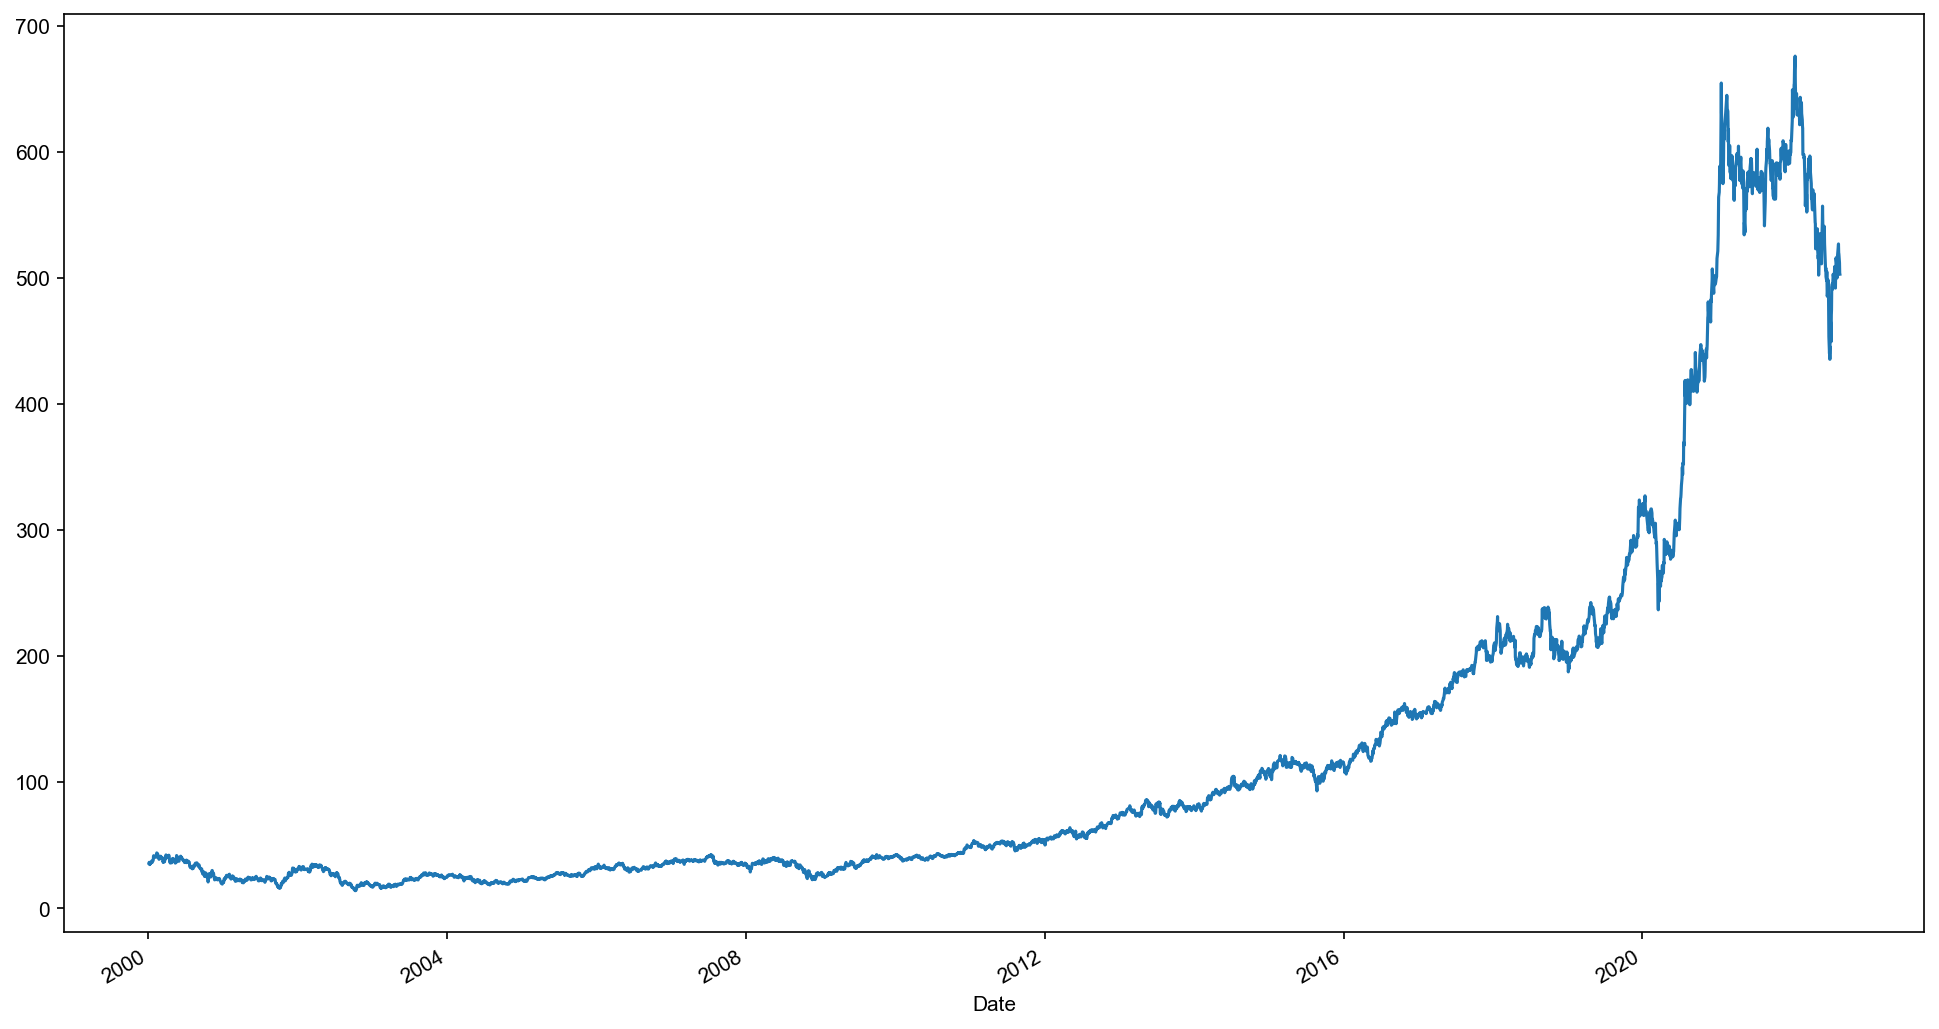

In [5]:
df['Close'].plot(figsize=(16, 9))

In [15]:
df.reset_index(drop=True, inplace=True)

lagging_features = ['High', 'Low', 'Open', 'Volume']

df_rolled_3d = df[lagging_features].rolling(window=3, min_periods=0)
df_rolled_7d = df[lagging_features].rolling(window=7, min_periods=0)
df_rolled_30d = df[lagging_features].rolling(window=30, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lagging_features:
    df[f"{feature}_mean_lag3"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag7"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag30"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag3"] = df_std_3d[feature]
    df[f"{feature}_std_lag7"] = df_std_7d[feature]
    df[f"{feature}_std_lag30"] = df_std_30d[feature]
    
df.fillna(df.mean(), inplace=True)

df.set_index("Date", drop=False, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,High_mean_lag3,High_mean_lag7,...,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-18,520.0,521.0,519.0,520.0,17831084,0.0,0.0,2022-08-18,525.666687,517.571411,...,23045560.0,22062628.0,27943594.0,3559309.00,2571775.75,9562550.0,8,33,18,3
2022-08-19,519.0,523.0,517.0,519.0,14022812,0.0,0.0,2022-08-19,524.666687,519.000000,...,21898200.0,21586444.0,26932922.0,4766415.50,3033040.75,8934822.0,8,33,19,4
2022-08-22,511.0,514.0,510.0,512.0,11494000,0.0,0.0,2022-08-22,523.666687,521.857117,...,19665666.0,20609504.0,26137086.0,6749791.50,4187241.75,8987616.0,8,34,22,0
2022-08-23,503.0,506.0,502.0,504.0,19191108,0.0,0.0,2022-08-23,519.333313,521.857117,...,14449299.0,18860072.0,25788830.0,3189982.75,5116420.50,9350862.0,8,34,23,1
2022-08-24,504.0,508.0,503.0,503.0,14782282,0.0,0.0,2022-08-24,514.333313,520.142883,...,14902640.0,18810812.0,25660652.0,3923245.25,5110486.00,9416020.0,8,34,24,2


In [14]:
df.Date = pd.to_datetime(df.Date, format="%Y-%m-%d")
df["month"] = df.Date.dt.month
df["week"] = df.Date.dt.week
df["day"] = df.Date.dt.day
df["day_of_week"] = df.Date.dt.dayofweek
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Date,High_mean_lag3,High_mean_lag7,...,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,35.802341,35.802341,35.198936,35.802341,200662336736,0.0,0.0,2000-01-04,122.460739,122.289520,...,2.013687e+10,2.023054e+10,2.069885e+10,8.130942e+09,1.009217e+10,1.242596e+10,1,1,4,1
2000-01-05,35.802335,36.606812,35.400001,36.606812,402466805912,0.0,0.0,2000-01-05,35.802341,35.802341,...,2.006623e+11,2.006623e+11,2.006623e+11,8.130942e+09,1.009217e+10,1.242596e+10,1,1,5,2
2000-01-06,36.405747,36.606818,35.802341,35.802341,197545715802,0.0,0.0,2000-01-06,36.204575,36.204575,...,3.015646e+11,3.015646e+11,3.015646e+11,1.426973e+11,1.426973e+11,1.426973e+11,1,1,6,3
2000-01-07,34.595522,35.198927,34.193187,34.796593,235270344752,0.0,0.0,2000-01-07,36.338657,36.338657,...,2.668916e+11,2.668916e+11,2.668916e+11,1.174219e+11,1.174219e+11,1.174219e+11,1,1,7,4
2000-01-10,35.802335,36.204478,35.198930,36.003407,276171685539,0.0,0.0,2000-01-10,36.137520,36.053726,...,2.784276e+11,2.589863e+11,2.589863e+11,1.090646e+11,9.716950e+10,9.716950e+10,1,2,10,0


In [17]:
df_train = df[df.Date < "2019"]
df_valid = df[df.Date >= "2019"]

exogenous_features = ['High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Open_mean_lag3', 'Open_mean_lag7',
       'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7',
       'Open_std_lag30', 'Volume_mean_lag3', 'Volume_mean_lag7',
       'Volume_mean_lag30', 'Volume_std_lag3', 'Volume_std_lag7',
       'Volume_std_lag30', 'month', 'week', 'day', 'day_of_week']

# ARIMAX Model

In [18]:
model = auto_arima(df_train.Close, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Close, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=20529.739, Time=8.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=20013.098, Time=5.59 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=20296.096, Time=5.33 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=20738.454, Time=7.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=55644.486, Time=5.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=20555.442, Time=8.09 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 45.081 seconds


<AxesSubplot:xlabel='Date'>

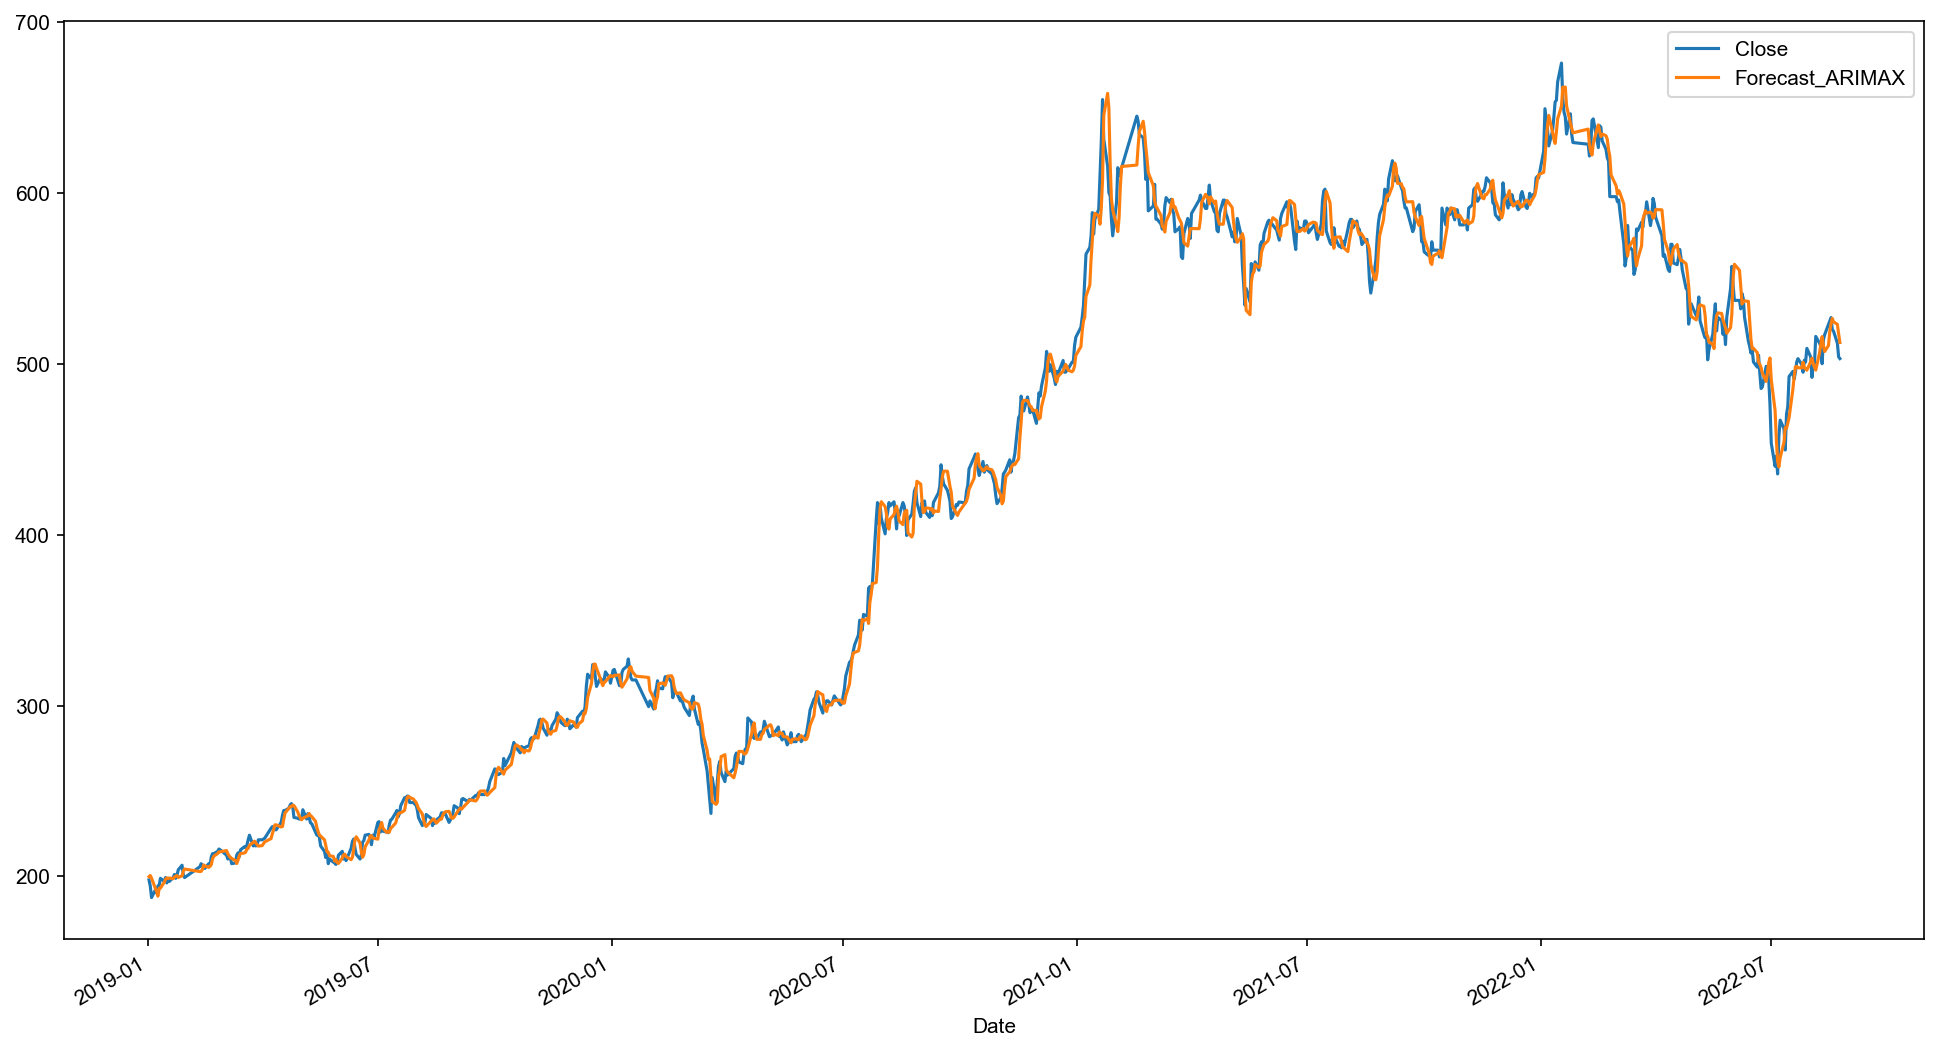

In [ ]:
df_valid[["Close", "Forecast_ARIMAX"]].plot(figsize=(16, 9))

In [ ]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX)))
print("MAE  of Auto ARIMAX:", mean_absolute_error(df_valid.Close, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 9.542232073400012
MAE  of Auto ARIMAX: 6.83280169777028


# Prophet

In [ ]:
model_fbp = Prophet()
for feature in exogenous_features:
    model_fbp.add_regressor(feature)

model_fbp.fit(df_train[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds", "Close": "y"}))

forecast = model_fbp.predict(df_valid[["Date", "Close"] + exogenous_features].rename(columns={"Date": "ds"}))
df_valid["Forecast_Prophet"] = forecast.yhat.values

01:34:45 - cmdstanpy - INFO - Chain [1] start processing
01:34:54 - cmdstanpy - INFO - Chain [1] done processing


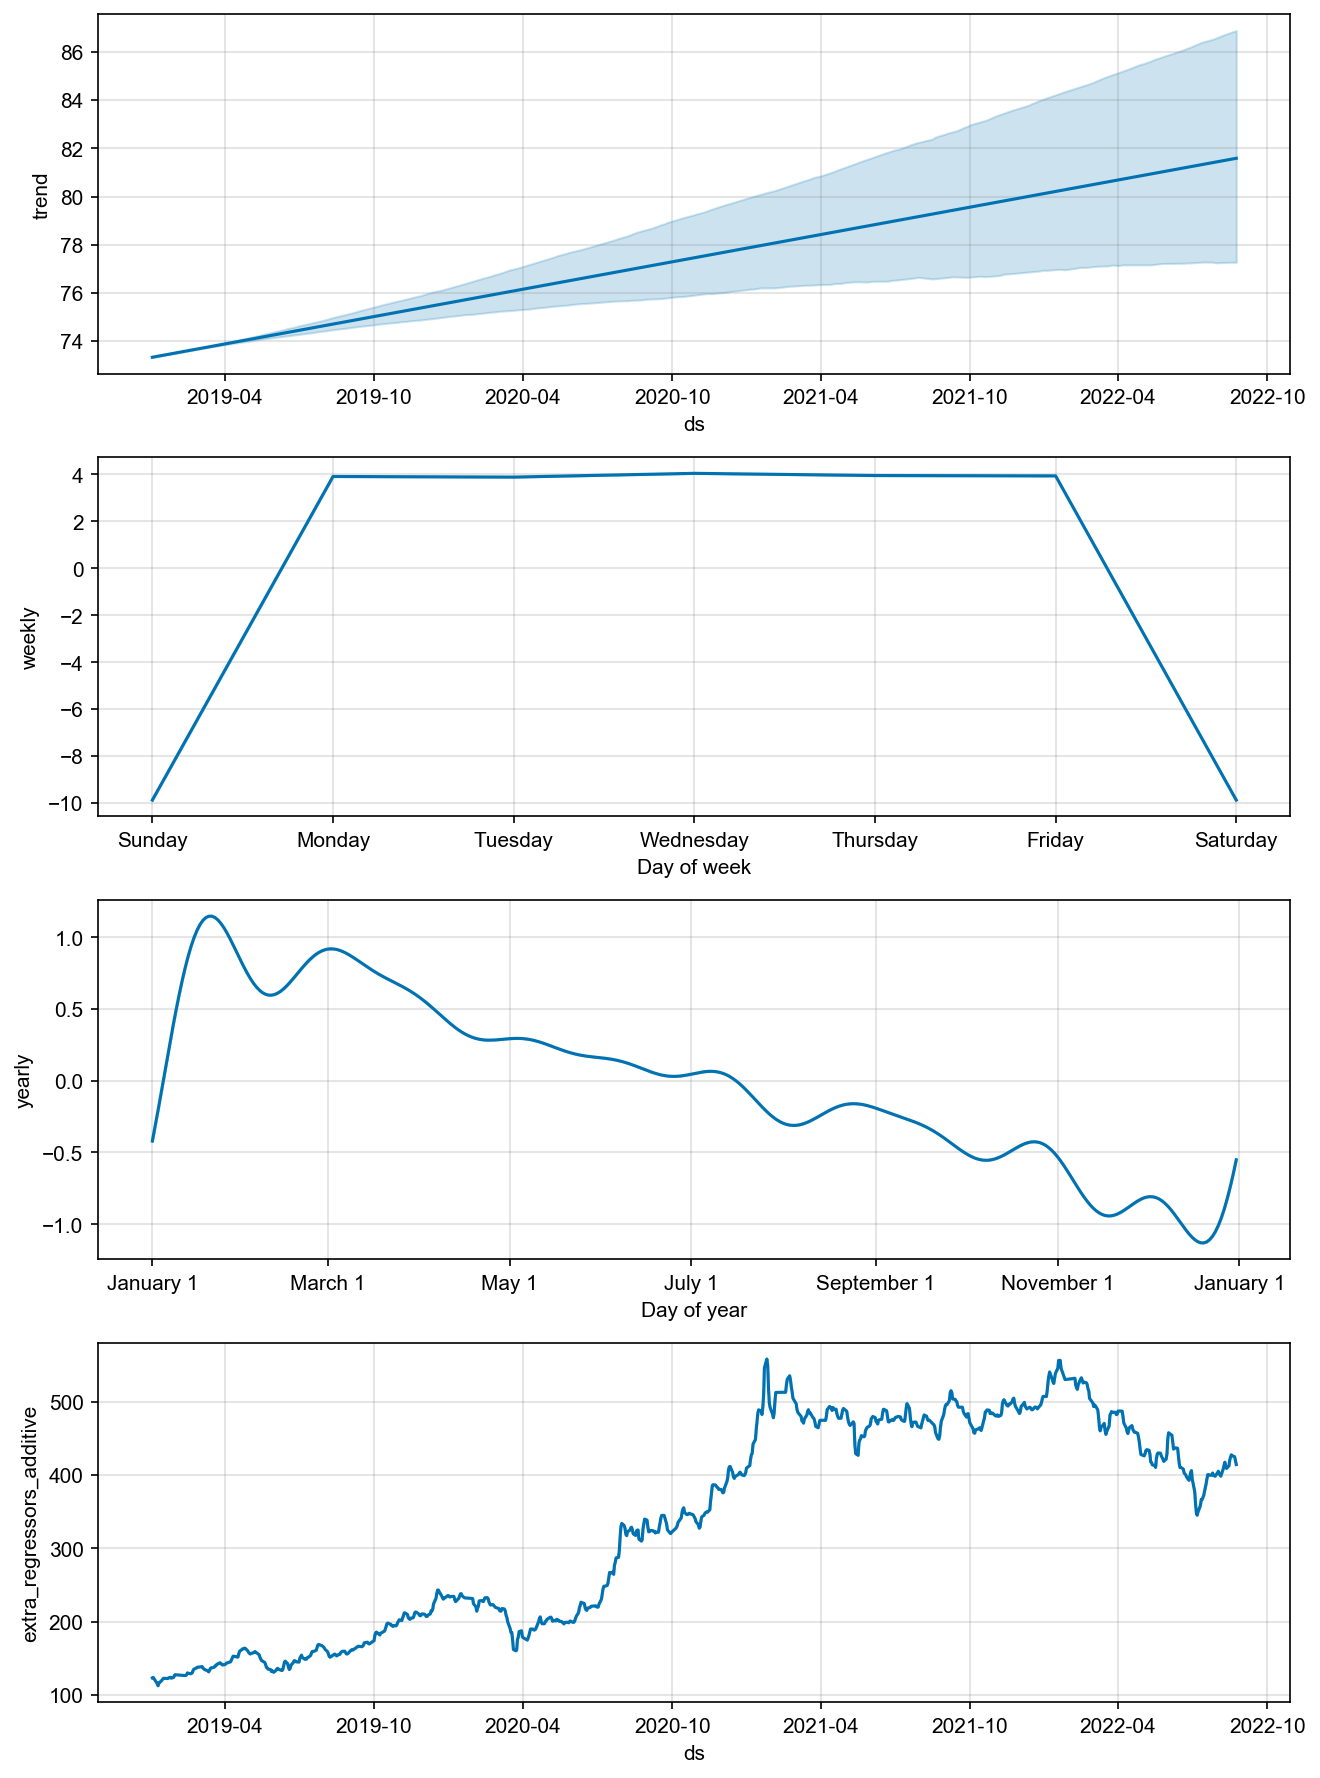

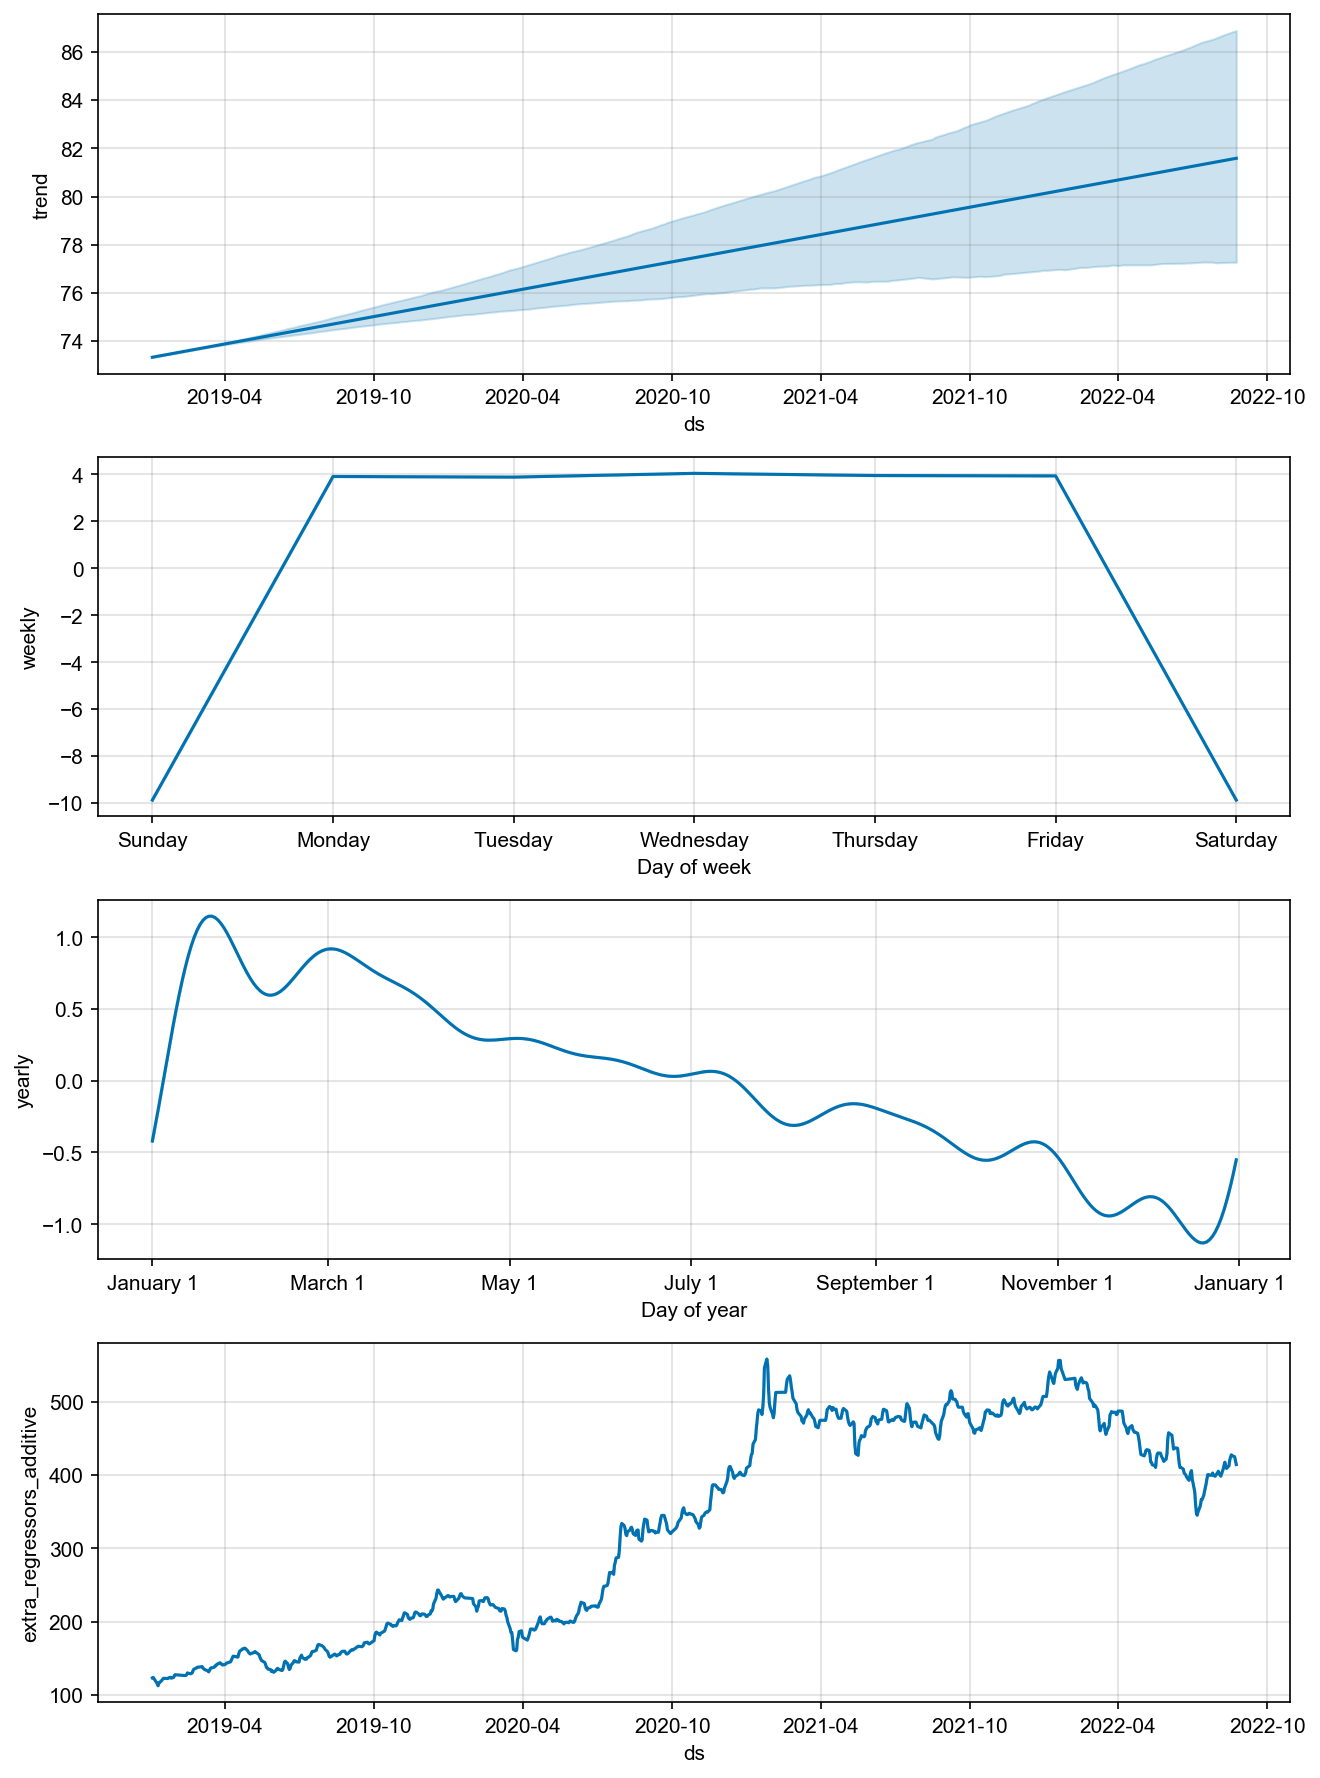

In [ ]:
model_fbp.plot_components(forecast)

<AxesSubplot:xlabel='Date'>

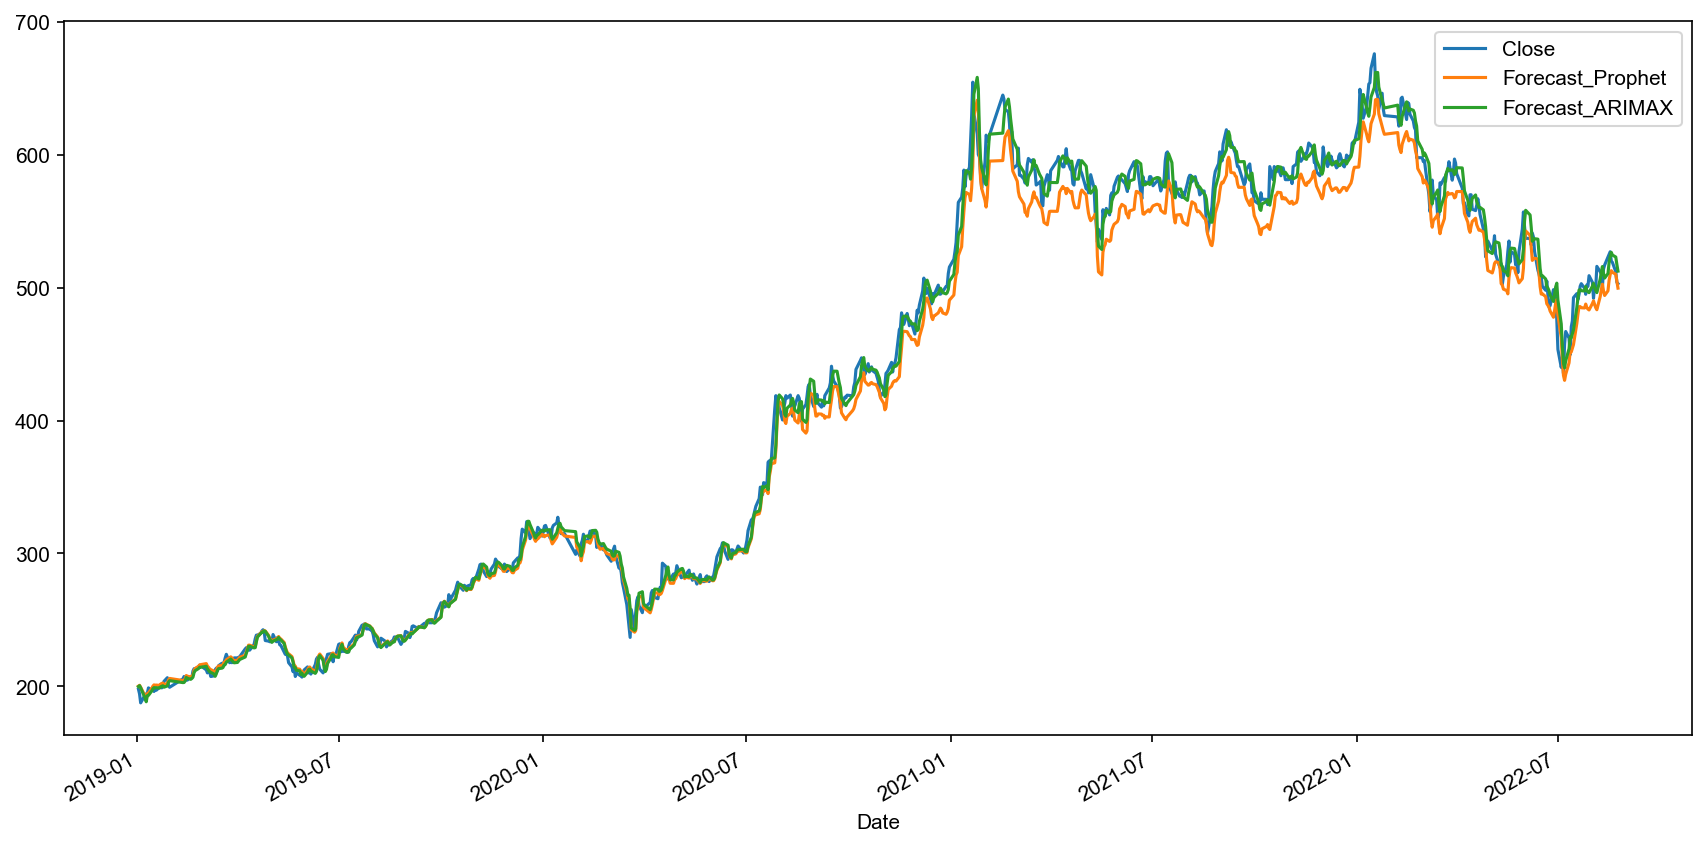

In [25]:
df_valid[["Close", "Forecast_Prophet", 'Forecast_ARIMAX']].plot(figsize=(14, 7))

In [ ]:
print("RMSE of Auto ARIMAX:\t", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_ARIMAX)))
print("RMSE of Prophet:\t", np.sqrt(mean_squared_error(df_valid.Close, df_valid.Forecast_Prophet)))
print("\nMAE  of Auto ARIMAX:\t", mean_absolute_error(df_valid.Close, df_valid.Forecast_ARIMAX))
print("MAE  of Prophet:\t", mean_absolute_error(df_valid.Close, df_valid.Forecast_Prophet))

RMSE of Auto ARIMAX:	 9.542232073400012
RMSE of Prophet:	 16.372098002143794

MAE  of Auto ARIMAX:	 6.83280169777028
MAE  of Prophet:	 12.26518461707087
